## Demonstration of alignment for cropping using PCA

This notebook demonstrates another possible approach to obtaining the region around the chest in mouse x-rays using PCA alignment.

### Plan
1. Threshold the image - using Otsu's method
2. Get x,y coordinates of binary region
3. Get mean x,y and covariance matrix
4. Do PCA on the covariance matrix to get eigenvectors and eigenvalues.
5. Use direction of largest Eigenvector to compute rotation for alignment with y-axis direction
6. Create Rigid body transformation object in SimpleITK and apply to image
4. Crop the aligned image using predefined ROI

### Requirements
1. [SimpleITK](https://simpleitk.readthedocs.io/en/master/)
2. [Matplotlib](https://matplotlib.org/)
3. [Numpy](https://numpy.org/)

In [1]:
# Import the dependencies
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import SimpleITK as sitk

The cell below defines utility functions. These were taken from the [SimpleITK examples](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html) and  modified for 2D images.

The cell below contains two utility functions I wrote. The first was necessary, because the DICOM images had a third dimension of 1-plane which is redundant and made SimpleITK think they were 3D images instead of 2D images. The third dimension is 'squeezed'. Also add a function to plot rectangles to ease showing ROIs on images

In [4]:
def squeeze_image(im):
    """Squeeze third dimension of sitk images (size 1) so they are 2D images
    
    """
    im_numpy = sitk.GetArrayFromImage(im)
    im_sitk = sitk.GetImageFromArray(np.squeeze(im_numpy))
    return im_sitk

def plot_rect(left, top, width, height, ax=None):
    
    right = left + width
    bottom = top + height
    x = [left, left,   right,  right, left]
    y = [top,  bottom, bottom, top,   top]
    if ax == None:
        ax = plt.gca()
    ax.plot(x, y, 'r')

In [17]:
# Read in the reference image. Assumed to be in the same dir as this notebook
fixed_image = sitk.ReadImage("reference_image.png", sitk.sitkFloat32)

# Read in the image to be aligned
# You need to provide your own image - see https://www.ebi.ac.uk/~kola/383185.dcm if you need to download one
moving_image = squeeze_image(sitk.ReadImage("382735.dcm", sitk.sitkFloat32))

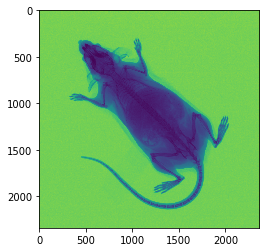

In [18]:
plt.imshow(sitk.GetArrayViewFromImage(moving_image))

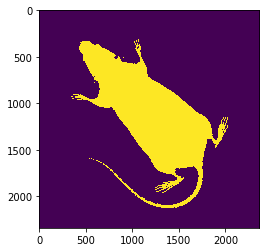

In [19]:
# Threshold image using Otsu's method
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(1)
otsu_filter.SetOutsideValue(0)
seg = sitk.GetArrayFromImage(otsu_filter.Execute(moving_image))
plt.imshow(seg)

In [20]:
# Get x,y coordinates of foreground and compute mean
y,x = np.nonzero(seg)
x = np.array(x, dtype=np.float64)
y = np.array(y, dtype=np.float64)
x_mean = x.mean()
y_mean = y.mean()

# Center data about mean
x -= x_mean
y -= y_mean

# Compute covariance matrix
m = np.stack((x, y), axis=0)
covariance = np.cov(m)
e_val, e_vec = np.linalg.eigh(covariance)
print(e_val, e_vec)


[ 47180.72313023 233535.02093968] [[-0.75144673  0.65979377]
 [ 0.65979377  0.75144673]]


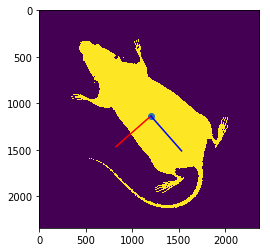

In [21]:
# Display on image
plt.imshow(seg)
plt.plot(x_mean,y_mean,'.',markersize=12)
plt.plot([x_mean, (x_mean+500*e_vec[0][0])], [y_mean, (y_mean+500*e_vec[0][1])], 'r')
plt.plot([x_mean, (x_mean+500*e_vec[0][1])], [y_mean, (y_mean+500*e_vec[1][1])], 'b')

In [24]:
# Compute the angle with the y axis
# The eigenvectors have been normalised, so dot product with unit vector in y direction (0,1) is the
# value of y coefficient of the eigenvector.

index = np.argmax(e_val)
angle = np.arccos(e_vec[1,index])
print(np.rad2deg(angle))

41.28414637316769


In [27]:
# Create Transform
transform = sitk.Euler2DTransform((x_mean,y_mean), angle)

In [29]:
transform.GetAngle()

0.7205442830870518

In [ ]:
ncc = sitk.NormalizedCorrelation

In [ ]:
# ROI parameters
left = 890
top = 400
width = 700
height = width

# Plot the reference and aligned images and overlay ROI
plt.figure(figsize=(12,10))

ax = plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayViewFromImage(fixed_image))
plot_rect(left, top, width, height)
ax.set_title('Reference')
plt.axis('off')

ax = plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayViewFromImage(moving_image))
plt.axis('off')
ax.set_title('Before')

ax = plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled))
plot_rect(left, top, width, height)
plt.axis('off')
ax.set_title('Aligned');


In [ ]:
# Display cropped image
moving_resampled_np = sitk.GetArrayFromImage(moving_resampled)
cropped_image = moving_resampled_np[top:top+height+1, left:left+width+1]
plt.imshow(cropped_image);